In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import os
import statsmodels

In [2]:
df=pd.DataFrame()
os.chdir('C:/Users/EliteBook/Desktop/')

In [3]:
df = pd.read_csv('Pump_price.csv',index_col='Date',parse_dates=True)


In [4]:
df = df.dropna()
df.head()

,Diesel_Pump_per_lit
Date,
2011-01-01,589.0
2011-02-01,561.0
2011-03-01,640.0
2011-04-01,656.0
2011-05-01,727.0


<AxesSubplot:xlabel='Date'>

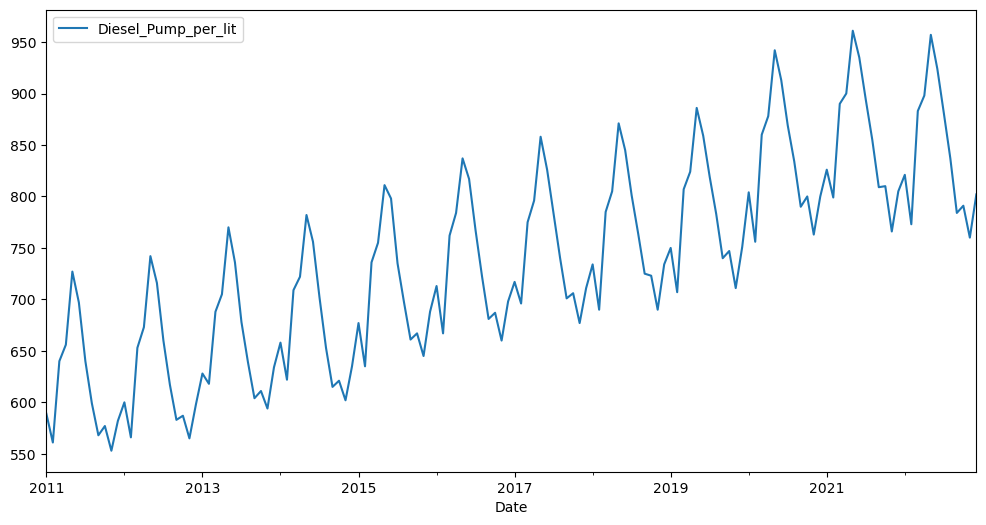

In [5]:
df.columns = ['Diesel_Pump_per_lit']
df.plot(figsize=(12,6))

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [7]:
results = seasonal_decompose(df['Diesel_Pump_per_lit'])

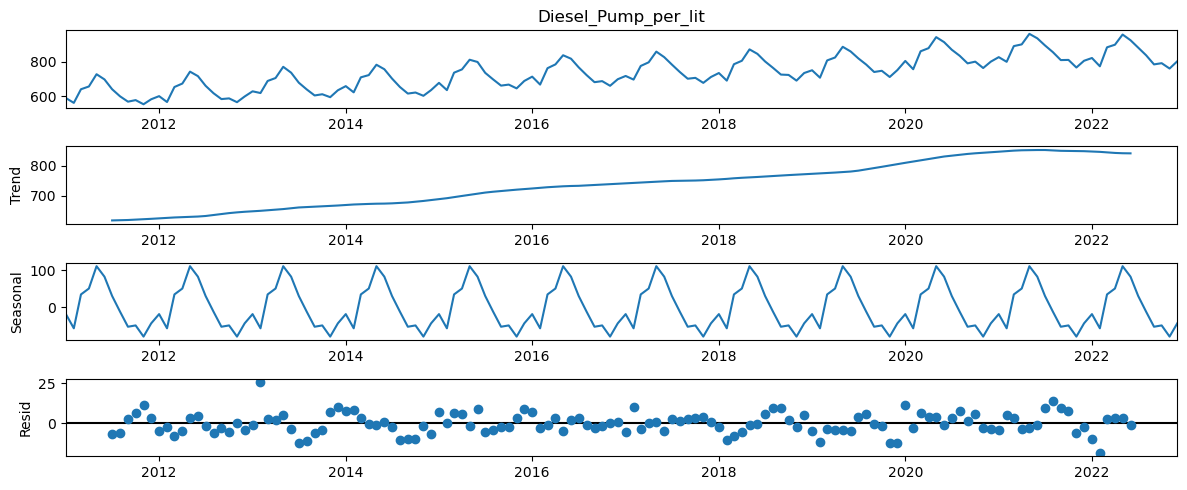

In [8]:
from pylab import rcParams
rcParams['figure.figsize'] = 12,5
results.plot();

In [9]:
len(df)

144

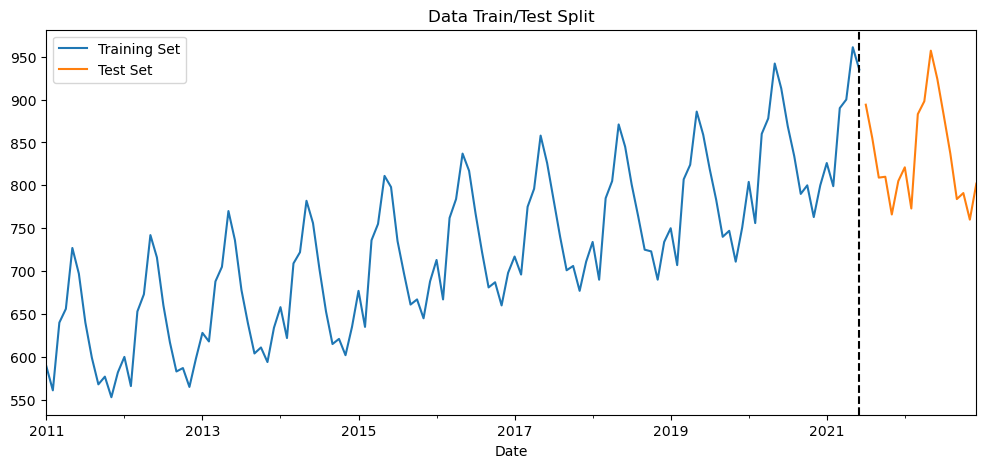

In [10]:
train = df.iloc[:126]
test = df.iloc[126:]
fig, ax = plt.subplots(figsize=(12, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('06-1-2021', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [12]:
df.head(),df.tail()

(            Diesel_Pump_per_lit
 Date                           
 2011-01-01                589.0
 2011-02-01                561.0
 2011-03-01                640.0
 2011-04-01                656.0
 2011-05-01                727.0,
             Diesel_Pump_per_lit
 Date                           
 2022-08-01                837.0
 2022-09-01                784.0
 2022-10-01                791.0
 2022-11-01                760.0
 2022-12-01                802.0)

In [13]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [14]:
scaled_train[:10]

array([[0.08823529],
       [0.01960784],
       [0.21323529],
       [0.25245098],
       [0.42647059],
       [0.35294118],
       [0.21323529],
       [0.1127451 ],
       [0.03676471],
       [0.05882353]])

In [15]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [16]:
# define generator
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [17]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.08823529 0.01960784 0.21323529]
Predict this y: 
 [[0.25245098]]


In [18]:
X.shape

(1, 3, 1)

In [19]:
# We do the same thing, but now instead for 12 months
n_input = 18
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [20]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [21]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [23]:
# fit model
model.fit(generator,epochs=50)

Epoch 1/50
108/108 [==============================] - 3s 9ms/step - loss: 0.0659
Epoch 2/50
108/108 [==============================] - 1s 9ms/step - loss: 0.0255
Epoch 3/50
108/108 [==============================] - 1s 9ms/step - loss: 0.0231
Epoch 4/50
108/108 [==============================] - 1s 10ms/step - loss: 0.0227
Epoch 5/50
108/108 [==============================] - 1s 9ms/step - loss: 0.0224
Epoch 6/50
108/108 [==============================] - 1s 10ms/step - loss: 0.0170
Epoch 7/50
108/108 [==============================] - 1s 10ms/step - loss: 0.0130
Epoch 8/50
108/108 [==============================] - 1s 10ms/step - loss: 0.0100
Epoch 9/50
108/108 [==============================] - 1s 8ms/step - loss: 0.0080
Epoch 10/50
108/108 [==============================] - 1s 8ms/step - loss: 0.0090
Epoch 11/50
108/108 [==============================] - 1s 8ms/step - loss: 0.0087
Epoch 12/50
108/108 [==============================] - 1s 9ms/step - loss: 0.0091
Epoch 13/50
108/108 [

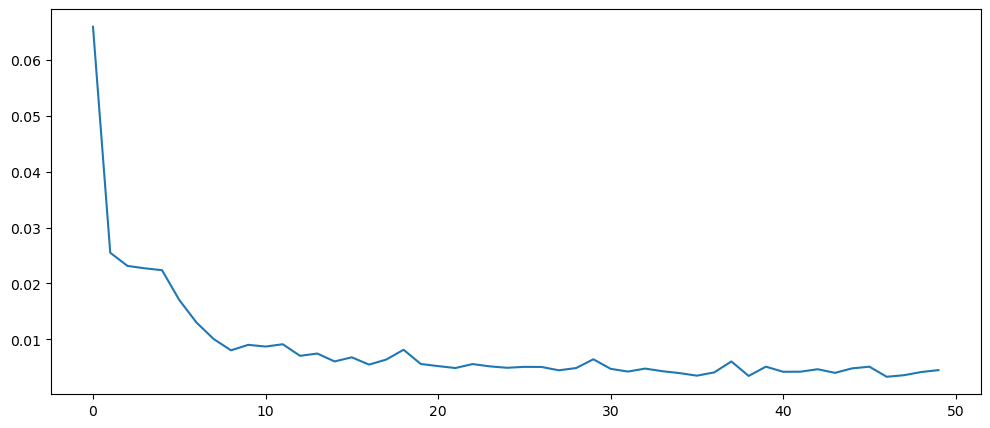

In [24]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [25]:
last_train_batch = scaled_train[-18:]

In [26]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [27]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 292ms/step


array([[0.78951263]], dtype=float32)

In [28]:
scaled_test[0]

array([0.83578431])

In [29]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 25ms/step


In [30]:
test_predictions

[array([0.78951263], dtype=float32),
 array([0.6731162], dtype=float32),
 array([0.59042186], dtype=float32),
 array([0.556886], dtype=float32),
 array([0.5518136], dtype=float32),
 array([0.5687009], dtype=float32),
 array([0.6050726], dtype=float32),
 array([0.66116387], dtype=float32),
 array([0.763033], dtype=float32),
 array([0.8609996], dtype=float32),
 array([0.9163008], dtype=float32),
 array([0.8592814], dtype=float32),
 array([0.73102605], dtype=float32),
 array([0.61572355], dtype=float32),
 array([0.5395356], dtype=float32),
 array([0.51490355], dtype=float32),
 array([0.51518625], dtype=float32),
 array([0.5371658], dtype=float32)]

In [31]:
true_predictions = scaler.inverse_transform(test_predictions)

In [32]:
test['Predictions'] = true_predictions

C:\Users\EliteBook\AppData\Local\Temp\ipykernel_15860\4269337381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


<AxesSubplot:xlabel='Date'>

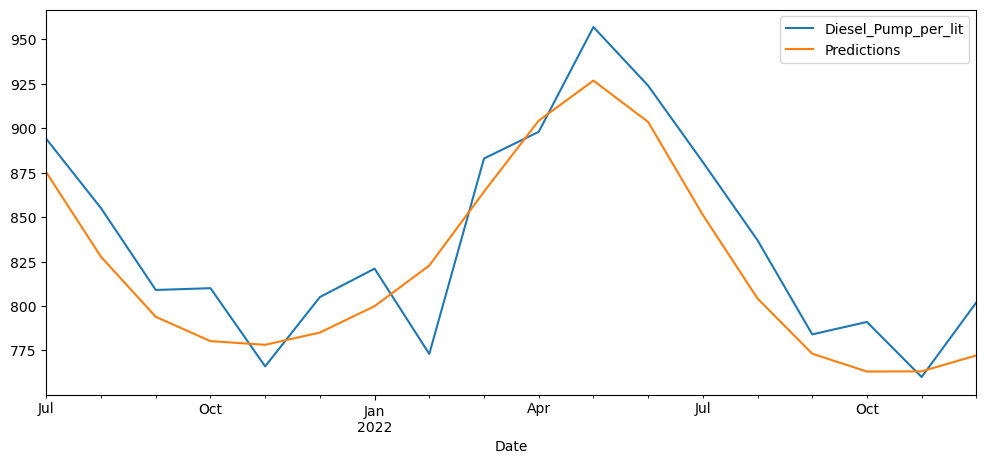

In [33]:
test.plot(figsize=(12,5))

In [34]:
test.head(),test.tail()

(            Diesel_Pump_per_lit  Predictions
 Date                                        
 2021-07-01                894.0   875.121155
 2021-08-01                855.0   827.631413
 2021-09-01                809.0   793.892117
 2021-10-01                810.0   780.209495
 2021-11-01                766.0   778.139950,
             Diesel_Pump_per_lit  Predictions
 Date                                        
 2022-08-01                837.0   804.215209
 2022-09-01                784.0   773.130517
 2022-10-01                791.0   763.080647
 2022-11-01                760.0   763.195990
 2022-12-01                802.0   772.163655)

In [35]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Diesel_Pump_per_lit'],test['Predictions']))
print(rmse)

24.901018165336623


<AxesSubplot:xlabel='Date'>

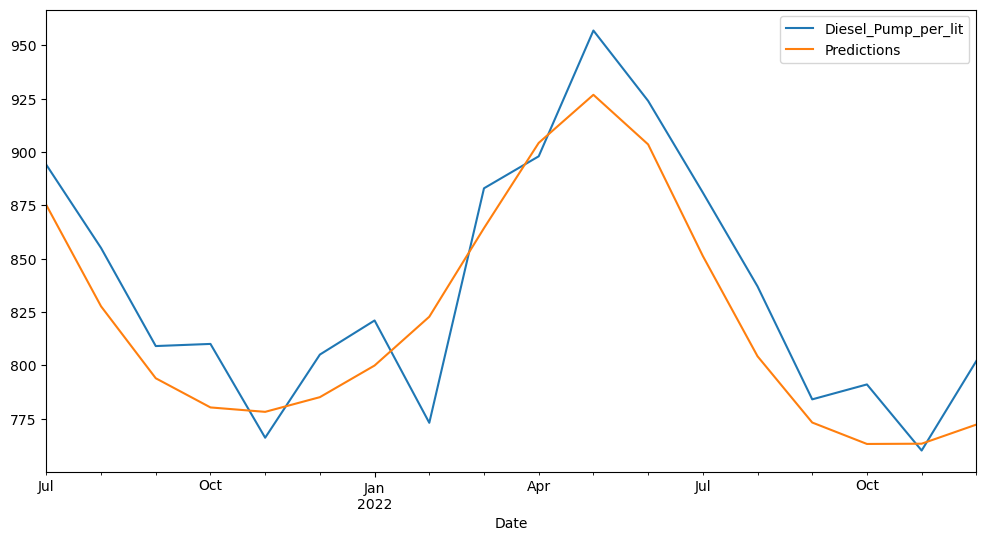

In [36]:
test.columns = ['Diesel_Pump_per_lit','Predictions']
test.plot(figsize=(12,6))